In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model as linear
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sb
import warnings
import missingno as msn
warnings.filterwarnings('ignore')

In [2]:
dhs_df = pd.read_csv("datasets/DHS_Data_By_Cell_with_Regression_Dat_AggregatedFoodGroups_27June2019.csv")

In [3]:
dhs_df.head()

,Cell_Order,fruits,Num_Households_Responded_fruits,vegetables,Num_Households_Responded_vegetables,dairy,Num_Households_Responded_dairy,eggs,Num_Households_Responded_eggs,meat_fish,...,Cons_kg.yr Eggs,"Cons_kg.yr Fish, Seafood",Cons_kg.yr Fruits - Excluding Wine,Cons_kg.yr Meat,Cons_kg.yr Milk - Excluding Butter,Cons_kg.yr Nuts_and_Seeds,Cons_kg.yr Pulses,Cons_kg.yr Starchy Roots,Cons_kg.yr Sugar & Sweeteners,Cons_kg.yr Vegetables
0,2158169,0.179487,13.0,0.494505,13.0,0.159341,13.0,0.346520,13.0,0.480220,...,17.324,15.084,52.856,51.040,156.888,2.434,1.542,135.794,47.558,154.956
1,2158170,0.227965,16.0,0.113839,16.0,0.353051,16.0,0.046875,16.0,0.280072,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622
2,2158171,0.166450,11.0,0.282359,11.0,0.319772,11.0,0.106585,11.0,0.136905,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622
3,2158173,0.321429,7.0,0.054945,7.0,0.877060,7.0,0.269231,7.0,0.153846,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622
4,2158174,0.207953,14.0,0.199923,14.0,0.190168,14.0,0.178890,14.0,0.086466,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622


### Preparing Dataset

In [4]:
# Merge with global data
production_df = pd.read_csv("datasets/production_avg_2011_2013.csv")
socio_economic_df = pd.read_csv("datasets/master.csv")

In [5]:
# This dataset does not have ISO3C GONNA add that. 
env_df = pd.read_excel("datasets/analysis4_environment_finaldata.xlsx")

In [6]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2,country_name_to_country_alpha3,country_alpha3_to_country_alpha2

In [7]:
def convert_to_iso3c(countries):
    """
    This function tries to get the continent based on Country name.
    Since some countries names are differnt in the library we are using here,
    need to manually change those.
    
    This function also tries to rechieve an alpha 3 Country Code based on the name. 
    """
    country_codes = []
    for country in countries:
        try:
            country_code = country_name_to_country_alpha3(country)
            country_codes.append(country_code)
        except KeyError:
            print(country)
            country_codes.append(country)
    return country_codes

In [8]:
country_codes = convert_to_iso3c(env_df["Country"])


Bolivia (Plurinational State of)
CÃ´te d'Ivoire
Channel Islands
China, Hong Kong SAR
China, Macao SAR
China, mainland
China, Taiwan Province of
Eswatini
Holy See
Iran (Islamic Republic of)
Micronesia (Federated States of)
Netherlands Antilles (former)
North Macedonia
Pitcairn Islands
RÃ©union
Republic of Korea
Sudan (former)
Svalbard and Jan Mayen Islands
Venezuela (Bolivarian Republic of)
Wallis and Futuna Islands


In [9]:
manual_country_code_dict = {"Bolivia (Plurinational State of)":"BOL"
                            ,"Channel Islands":""
                         ,"China, Hong Kong SAR":"HKG"
                         ,"China, mainland":"CHN"
                         ,"China, Macao SAR":"MAC"
                         ,"China, Taiwan Province of":"TWN"
                         ,"Holy See":"VAT"
                         ,"CÃƒÂ´te d'Ivoire":"CIV"
                            ,"CÃ´te d'Ivoire":"CIV"
                        ,"Pitcairn Islands":"PCN"
                        ,"Iran (Islamic Republic of)":"IRN"
                        ,"Republic of Korea":"KOR"
                        ,"Eswatini":"SWZ"
                        ,"RÃ©union":"REU"
                        ,"Netherlands Antilles (former)":"ANT"
                        ,"Svalbard and Jan Mayen Islands":"SJM"
                        ,"Sudan (former)":"SDN"
                        ,"North Macedonia":"MKD"
                        ,"Republic of North Macedonia":"MKD"
                        ,"Timor-Leste":"TLS"
                        ,"Wallis and Futuna Islands":"WLF"
                        ,"Venezuela (Bolivarian Republic of)":"VEN"}


In [10]:
# principalDf.to_csv("test.csv")
env_df["ISO3C"] = country_codes
env_df["ISO3C"] = env_df["ISO3C"].replace(manual_country_code_dict)

In [11]:
dhs_merged_df = dhs_df.merge(socio_economic_df, how="left", left_on= "ISO3C", right_on = "Country Code")
dhs_merged_env_df = dhs_merged_df.merge(env_df, how="left", on= "ISO3C")
dhs_ml_df = dhs_merged_env_df.merge(production_df,how = "left",left_on = "ISO3C",right_on = "Code")

In [12]:
dhs_ml_df.columns

Index(['Cell_Order', 'fruits', 'Num_Households_Responded_fruits', 'vegetables',
       'Num_Households_Responded_vegetables', 'dairy',
       'Num_Households_Responded_dairy', 'eggs',
       'Num_Households_Responded_eggs', 'meat_fish',
       'Num_Households_Responded_meat_fish', 'nuts_pulses',
       'Num_Households_Responded_nuts_pulses', 'sweets',
       'Num_Households_Responded_sweets', 'grains_tubers',
       'Num_Households_Responded_grains_tubers', 'animal_source_foods',
       'Num_Households_Responded_animal_source_foods', 'Cell_Order.1', 'ISO3N',
       'Primary_Religion', 'Percent_Primary_Religion', 'Percent_Christian',
       'GDP_PPP_2015', 'GDP_PPP_2000', 'GDP_PPP_1990', 'Population_2015',
       'Population_2000', 'Population_1990', 'Travel_time_to_cities',
       'Soil_suit_overall', 'Soil_suit_cereals', 'Soil_suit_fruits',
       'Soil_suit_veges', 'Soil_suit_nuts_seeds', 'Soil_suit_pulses',
       'Soil_suit_roots', 'Soil_suit_chocolate', 'Soil_suit_coffee',
       

In [13]:
# Before finding a dataset with better percapita GDP, I am not going to use that for the prediction. 
# There is just too much missing data.

# dhs_predictor_socio_cols = ['PerCapita_GDP_2015','agri_gdp_percentage(AVG from 2011 to 2013)',
#                            'AVG GDP 2011-2013 Constant 2010']

dhs_predictor_socio_cols = ['ari_employment value (AVG 2011-2013)',
                            'agri_gdp_percentage(AVG from 2011 to 2013)',
                           'AVG GDP 2011-2013 Constant 2010']

dhs_predictor_consump_cols = ['Cons_kg.yr Cereals - Excluding Beer', 'Cons_kg.yr Eggs'
                        ,'Cons_kg.yr Fish, Seafood'
                       ,'Cons_kg.yr Meat', 'Cons_kg.yr Milk - Excluding Butter'
                       ,'Cons_kg.yr Nuts_and_Seeds', 'Cons_kg.yr Pulses'
                       ,'Cons_kg.yr Starchy Roots']

# Protected Marine is missing so much. Not using here. 
dhs_predictor_env_cols = ['Agricultural Emissions (CO2eq)'
                           ,'Protected_Terrestrial'
                          , 'Forest_change' 
                          , 'Redlist'
                         ,'Freshwater']

dhs_predictor_production_cols = ['Fish, Seafood', 'Bovine_Sheep_Pigmeat_Poultry', 'Milk_Egg', 'Cereals']
                    
dhs_predictor_other_cols = ['Population_2015','Primary_Religion', 'Travel_time_to_cities','Soil_suit_overall', 'Soil_suit_cereals']

dhs_outcome_cols = ['eggs','dairy','meat_fish','nuts_pulses','grains_tubers','animal_source_foods']


In [14]:
dhs_ml_final_df = dhs_ml_df[dhs_predictor_socio_cols + \
                      dhs_predictor_consump_cols + \
                            dhs_predictor_env_cols +\
                      dhs_predictor_production_cols +\
                     dhs_predictor_other_cols +\
                        dhs_outcome_cols + ["Cell_Order"]]

In [15]:
dhs_ml_final_df.head()

,ari_employment value (AVG 2011-2013),agri_gdp_percentage(AVG from 2011 to 2013),AVG GDP 2011-2013 Constant 2010,Cons_kg.yr Cereals - Excluding Beer,Cons_kg.yr Eggs,"Cons_kg.yr Fish, Seafood",Cons_kg.yr Meat,Cons_kg.yr Milk - Excluding Butter,Cons_kg.yr Nuts_and_Seeds,Cons_kg.yr Pulses,...,Travel_time_to_cities,Soil_suit_overall,Soil_suit_cereals,eggs,dairy,meat_fish,nuts_pulses,grains_tubers,animal_source_foods,Cell_Order
0,20.081334,8.266235,1.440000e+11,140.708,17.324,15.084,51.040,156.888,2.434,1.542,...,82.41833,8.561080,8.491615,0.346520,0.159341,0.480220,0.159341,0.841392,0.986081,2158169
1,27.596000,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,74.77269,8.511680,8.491615,0.046875,0.353051,0.280072,0.074219,0.447915,0.679998,2158170
2,27.596000,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,96.45230,8.313398,8.491615,0.106585,0.319772,0.136905,0.150000,0.609615,0.563262,2158171
3,27.596000,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,92.95013,7.087249,6.998866,0.269231,0.877060,0.153846,0.075549,0.756868,1.300137,2158173
4,27.596000,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,104.31820,6.766561,6.492069,0.178890,0.190168,0.086466,0.182649,0.686842,0.455523,2158174


In [16]:
def overview(df):
    """
    This is a method to show number of missing values in our dataset.
    """
    print("Datasets shape Rows:{} Columns:{}".format(df.shape[0],df.shape[1]))
    print("----------Number of Missing Values in Each Column------------")
    nan_series = df.isnull().sum(axis = 0)
    print(nan_series)
    print("-------------------------------------------------------------")
    nan_series_trun = df.isnull().sum(axis = 1)
    print("Number of rows with more than 2 missing values:{}".format(nan_series_trun[nan_series_trun > 2].shape))
    # Number of empty data in rows
    print("Number of rows with 0 missing values:{}".format(nan_series_trun[nan_series_trun == 0].shape))


Datasets shape Rows:33648 Columns:32
----------Number of Missing Values in Each Column------------
ari_employment value (AVG 2011-2013)           1067
agri_gdp_percentage(AVG from 2011 to 2013)     1070
AVG GDP 2011-2013 Constant 2010                1070
Cons_kg.yr Cereals - Excluding Beer            1767
Cons_kg.yr Eggs                                1767
Cons_kg.yr Fish, Seafood                       1767
Cons_kg.yr Meat                                1767
Cons_kg.yr Milk - Excluding Butter             1767
Cons_kg.yr Nuts_and_Seeds                      1767
Cons_kg.yr Pulses                              1776
Cons_kg.yr Starchy Roots                       1767
Agricultural Emissions (CO2eq)                 1064
Protected_Terrestrial                          1489
Forest_change                                  1489
Redlist                                        1489
Freshwater                                     1489
Fish, Seafood                                  1778
Bovine_Sheep_Pigm

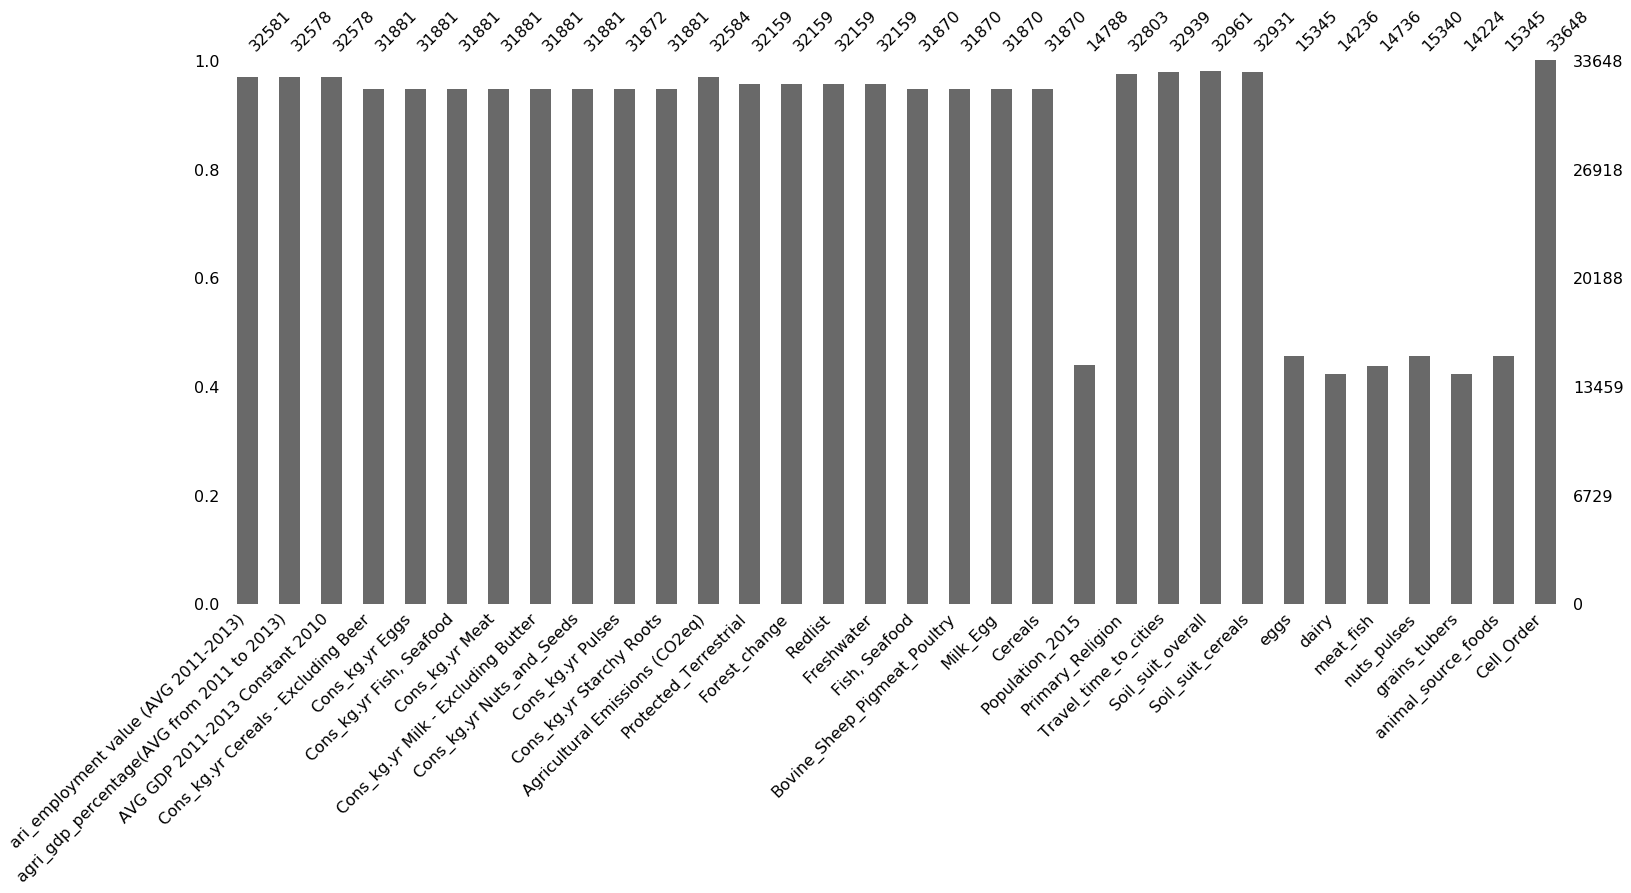

In [17]:
# Her Let's take a look at out dataset and visualize the missing values
overview(dhs_ml_final_df)
msn.bar(dhs_ml_final_df)

In [18]:
# Describe the df for later binning 
dhs_ml_final_df.describe()

,ari_employment value (AVG 2011-2013),agri_gdp_percentage(AVG from 2011 to 2013),AVG GDP 2011-2013 Constant 2010,Cons_kg.yr Cereals - Excluding Beer,Cons_kg.yr Eggs,"Cons_kg.yr Fish, Seafood",Cons_kg.yr Meat,Cons_kg.yr Milk - Excluding Butter,Cons_kg.yr Nuts_and_Seeds,Cons_kg.yr Pulses,...,Travel_time_to_cities,Soil_suit_overall,Soil_suit_cereals,eggs,dairy,meat_fish,nuts_pulses,grains_tubers,animal_source_foods,Cell_Order
count,32581.000000,32578.000000,3.257800e+04,31881.000000,31881.000000,31881.000000,31881.000000,31881.000000,31881.000000,31872.000000,...,32939.000000,32961.000000,32931.000000,15345.000000,14236.000000,14736.000000,15340.000000,14224.000000,15345.000000,3.364800e+04
mean,46.679840,18.176058,9.091100e+11,144.706844,2.950986,9.126167,15.445106,60.463532,7.486044,10.156463,...,84.798110,3.688729,4.846408,0.179753,0.307593,0.214108,0.214947,0.771712,0.660764,3.969616e+06
std,14.934237,9.091879,8.990694e+11,30.458665,2.708166,9.451910,15.959489,41.710871,4.752528,5.416853,...,182.562834,2.446650,1.706362,0.180282,0.292580,0.180763,0.196897,0.307004,0.427353,8.370142e+05
min,0.623667,1.364670,9.170050e+08,45.702000,0.230000,0.070000,4.066000,2.764000,0.004000,0.002000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.158169e+06
25%,42.874667,13.700025,2.292143e+10,131.332000,1.868000,5.250000,4.246000,31.192000,4.804000,6.698000,...,15.276630,1.522746,3.683363,0.055462,0.125000,0.080890,0.085714,0.607393,0.400754,3.346846e+06
50%,47.521333,17.061925,3.200000e+11,151.158000,2.012000,5.250000,8.174000,69.348000,7.328000,11.668000,...,36.842740,4.077061,4.945596,0.142929,0.250000,0.201016,0.172891,0.752357,0.621857,3.804738e+06
75%,47.521333,18.852912,1.870000e+12,151.158000,2.820000,7.790000,20.950000,69.348000,7.328000,11.668000,...,89.269055,5.743971,5.965635,0.246375,0.400000,0.305816,0.285714,0.916667,0.839160,4.399012e+06
max,91.581001,52.047069,7.200000e+12,257.928000,18.566000,52.438000,97.278000,336.916000,31.880000,35.386000,...,4653.946000,8.809972,8.998034,1.000000,3.000000,2.000000,1.000000,2.000000,6.000000,6.452155e+06


In [19]:
def draw_heat_map(df):
    """This is a function that uses seaborn's heatmap function to show correlations between our predictors and the outcome variables. """
    df_mat = df.corr()
    df_fig = plt.figure(figsize = (15,15))
    sb.heatmap(df_mat, vmax = .9, square = True, annot=True)

In [20]:


def separate_training_testing(myData):
    """
    This function seperates the training sets and validation sets.
    """
    valueArray = myData.values
    X = valueArray[:, 0:myData.shape[1] - 1]
    Y = valueArray[:, myData.shape[1] - 1]
    test_size = 0.15
    seed = 7
    X_train, X_validate, Y_train, Y_validate = train_test_split(X, Y, test_size=test_size, random_state=seed)
    return X_train, X_validate, Y_train, Y_validate


In [21]:
# Check if there is any low variance 
# Code from https://www.programcreek.com/python/example/93973/sklearn.feature_selection.VarianceThreshold
def feature_select(df):
    x_train, x_test, y_train, y_test = separate_training_testing(df)
    selector = VarianceThreshold()
    selector.fit(x_train, y_train)

    # Retain the feature names
    features = selector.get_support(indices = True)  # Returns array of indexes of nonremoved features
#     features = [column for column in df[features] if column != target]  # Gets feature names
    print(features)

### Machine Learning 

In [22]:
def string_to_int(df, col_name):
    """
    This is a helper function for converting the string labels to numerical
    """
    m = {}
    for i,e in enumerate(df[col_name].unique()):
        m.update({e: i})
    return m

In [23]:
def create_bins_width(df, col_name, bin_width):
    """
    This function cuts bins using equal width method
    """
    max = df[col_name].max()
    min = df[col_name].min()
    bins = np.arange(min, max, bin_width)
    print('This cuts the {} array into {} bins in equal width'.format(col_name,len(bins)))
    new_col_name = col_name + "_group"
    df[new_col_name] = np.digitize(df[col_name], bins)
    return df


def create_bins_depth(df, col_name, bin_num):
    """
    This function cuts bins using equal depth method
    """
    new_col_name = col_name + "_group"
    df[new_col_name],bins= pd.qcut(df[col_name],bin_num, retbins=True, labels=list(range(bin_num)))
    print('This cuts the {} array into {} result in {} bins in equal depth'.format(col_name,bins,bin_num))
    df[new_col_name] = df[new_col_name].astype(int)
    df = df.drop(col_name, axis=1)
    return df 

In [24]:
def clean_data(df):
    #   Making an assumption here that NA religion is no religion. 
    df["Primary_Religion"] = df["Primary_Religion"].fillna("No Religion")
    
    result_df = df.dropna()
    
    m = string_to_int(result_df, "Primary_Religion")
    result_df["Primary_Religion"] = result_df["Primary_Religion"].map(m)
    create_bins_width(result_df,"Travel_time_to_cities",10)
    create_bins_width(result_df,"Soil_suit_overall",2)
    create_bins_width(result_df,"Soil_suit_cereals",2)
    
    for c in dhs_predictor_consump_cols:
        result_df = create_bins_width(result_df,c,5)
    
    for p in dhs_predictor_production_cols:
        result_df = create_bins_width(result_df,p,500)
        
    create_bins_width(result_df,'ari_employment value (AVG 2011-2013)',5)
    create_bins_width(result_df,'Agricultural Emissions (CO2eq)',10000)
    create_bins_width(result_df,'Protected_Terrestrial',10)
    create_bins_width(result_df,'Forest_change',1)
    create_bins_width(result_df,'Redlist',0.15)
    create_bins_width(result_df,'Freshwater',2)
    
    
    result_df["agri_gdp_percentage(AVG from 2011 to 2013)"].astype(float,inplace = True)
    result_df["AVG GDP 2011-2013 Constant 2010"].astype(float,inplace = True)
    
#     create_bins_width(result_df,"PerCapita_GDP_2015",1000)
    create_bins_width(result_df,"Population_2015",5000)
    
    create_bins_width(result_df,"agri_gdp_percentage(AVG from 2011 to 2013)",5)
    create_bins_width(result_df,"AVG GDP 2011-2013 Constant 2010",1000000)
    
    return result_df

In [25]:
def clean_outcome(df,col):
    df.dropna(inplace = True)
    if col == "eggs" or col == "nuts_pulses":
        result_df = create_bins_width(df,col,0.25)
    else:
        result_df = create_bins_width(df,col,0.5)
    
    result_df = result_df[[col+'_group',"Cell_Order"]]
    return result_df
    

In [26]:
# Gather the desired cols that we will be using. 
desired_cols = dhs_predictor_socio_cols + \
                      dhs_predictor_consump_cols + \
                      dhs_predictor_production_cols +\
                    dhs_predictor_env_cols +\
                     dhs_predictor_other_cols 

# Instead of dropping na with the whole dataset which might cause loosing data entries, I am going to seperate the outcome variabels.
cleaned_dhs_df = clean_data(dhs_ml_final_df[desired_cols + ["Cell_Order"]])

This cuts the Travel_time_to_cities array into 322 bins in equal width
This cuts the Soil_suit_overall array into 5 bins in equal width
This cuts the Soil_suit_cereals array into 5 bins in equal width
This cuts the Cons_kg.yr Cereals - Excluding Beer array into 43 bins in equal width
This cuts the Cons_kg.yr Eggs array into 4 bins in equal width
This cuts the Cons_kg.yr Fish, Seafood array into 11 bins in equal width
This cuts the Cons_kg.yr Meat array into 19 bins in equal width
This cuts the Cons_kg.yr Milk - Excluding Butter array into 67 bins in equal width
This cuts the Cons_kg.yr Nuts_and_Seeds array into 7 bins in equal width
This cuts the Cons_kg.yr Pulses array into 8 bins in equal width
This cuts the Cons_kg.yr Starchy Roots array into 81 bins in equal width
This cuts the Fish, Seafood array into 114 bins in equal width
This cuts the Bovine_Sheep_Pigmeat_Poultry array into 162 bins in equal width
This cuts the Milk_Egg array into 272 bins in equal width
This cuts the Cereals 

In [27]:
desired_group_cols = [i+"_group" for i in desired_cols]
desired_group_cols.append("Cell_Order")
desired_group_cols.remove('Primary_Religion_group')
cleaned_dhs_grouped_df = cleaned_dhs_df[desired_group_cols] 

In [150]:
cleaned_egg_df = clean_outcome(dhs_ml_final_df[["eggs","Cell_Order"]],"eggs")
cleaned_ml_egg_df = cleaned_egg_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
cleaned_ml_egg_df = cleaned_ml_egg_df[desired_group_cols + ["eggs_group"]]
cleaned_ml_egg_df.drop(["Cell_Order"], axis=1,inplace = True)
cleaned_ml_egg_df.head()

This cuts the eggs array into 4 bins in equal width


,ari_employment value (AVG 2011-2013)_group,agri_gdp_percentage(AVG from 2011 to 2013)_group,AVG GDP 2011-2013 Constant 2010_group,Cons_kg.yr Cereals - Excluding Beer_group,Cons_kg.yr Eggs_group,"Cons_kg.yr Fish, Seafood_group",Cons_kg.yr Meat_group,Cons_kg.yr Milk - Excluding Butter_group,Cons_kg.yr Nuts_and_Seeds_group,Cons_kg.yr Pulses_group,...,Agricultural Emissions (CO2eq)_group,Protected_Terrestrial_group,Forest_change_group,Redlist_group,Freshwater_group,Population_2015_group,Travel_time_to_cities_group,Soil_suit_overall_group,Soil_suit_cereals_group,eggs_group
0,4,2,143040,20,4,4,10,31,1,1,...,3,1,6,2,5,1,9,5,5,2
1,6,2,6613,21,2,3,7,31,1,1,...,1,1,1,3,5,1,8,5,5,1
2,6,2,6613,21,2,3,7,31,1,1,...,1,1,1,3,5,1,10,5,5,1
3,6,2,6613,21,2,3,7,31,1,1,...,1,1,1,3,5,2,10,4,4,2
4,4,2,143040,20,4,4,10,31,1,1,...,3,1,6,2,5,4,6,5,5,1


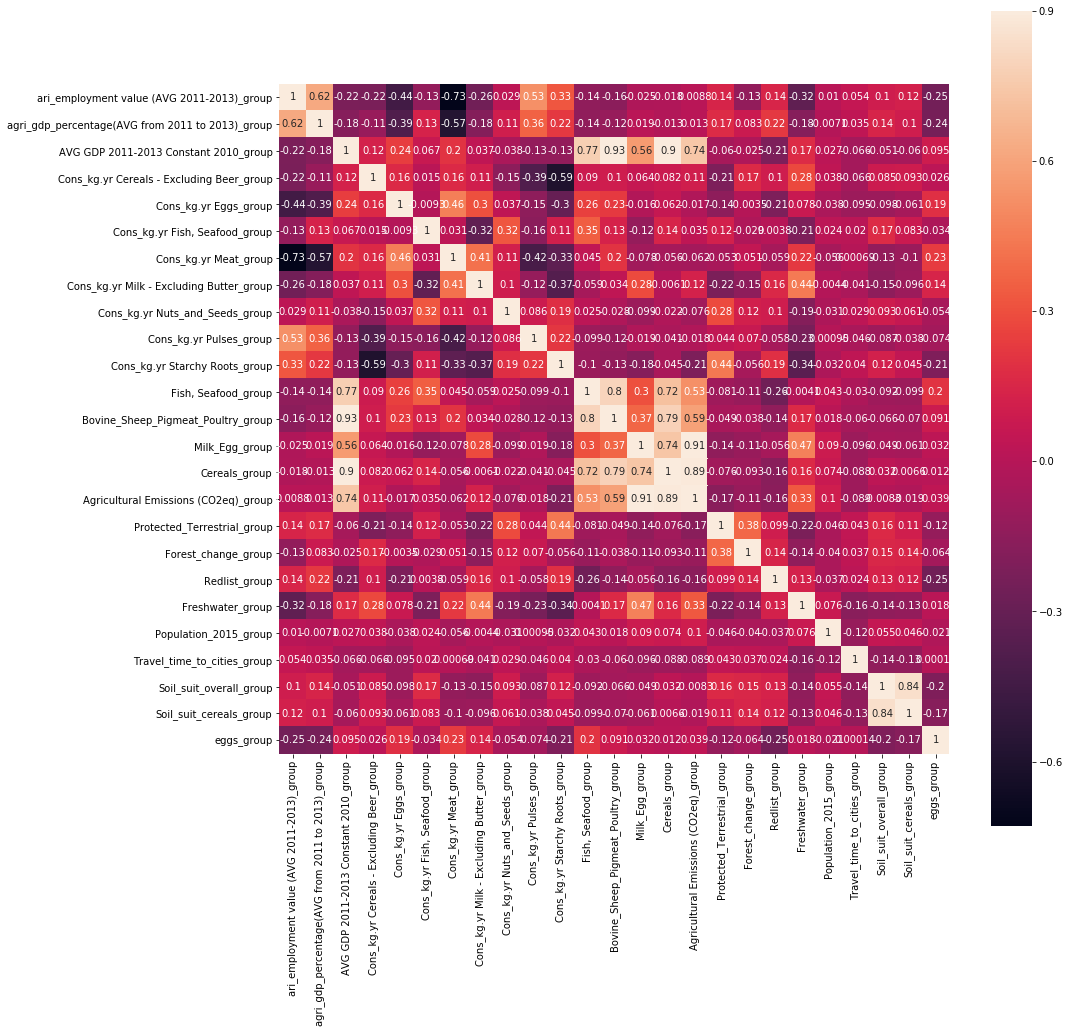

In [151]:
# Let's look at the heapmap
draw_heat_map(cleaned_ml_egg_df)

In [38]:
overview(cleaned_ml_egg_df)

Datasets shape Rows:6242 Columns:19
----------Number of Missing Values in Each Column------------
agri_gdp_percentage(AVG from 2011 to 2013)_group    0
AVG GDP 2011-2013 Constant 2010_group               0
Cons_kg.yr Cereals - Excluding Beer_group           0
Cons_kg.yr Eggs_group                               0
Cons_kg.yr Fish, Seafood_group                      0
Cons_kg.yr Meat_group                               0
Cons_kg.yr Milk - Excluding Butter_group            0
Cons_kg.yr Nuts_and_Seeds_group                     0
Cons_kg.yr Pulses_group                             0
Cons_kg.yr Starchy Roots_group                      0
Fish, Seafood_group                                 0
Bovine_Sheep_Pigmeat_Poultry_group                  0
Milk_Egg_group                                      0
Cereals_group                                       0
Population_2015_group                               0
Travel_time_to_cities_group                         0
Soil_suit_overall_group               

In [39]:
# I am also interested in precision and recall score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [100]:
def draw_roc_curve(name, model, X_validate, Y_validate):
    """
    This functions draws ROC graphs.
    """
    predicted_probas = model.predict_proba(X_validate)
    skplt.metrics.plot_roc(Y_validate, predicted_probas, title = "Roc Curve of {}".format(name))
    plt.show()
    # uncomment here to save the plots
    # plt.savefig(name)


def plot_confusion_matrix(Y_pred, Y_validate, name, out_come):
    """
    This function plots the confusion matrix.
    """

    skplt.metrics.plot_confusion_matrix(Y_validate, Y_pred,title = "Predicting {} Using {} Confusion Matrix".format(out_come, name))
    plt.show()
    
    # uncomment here to save the plots(Included in the write-up)
    # plt.savefig("cnf_matrix " + name)


def model_evaluate(X_train, X_validate, Y_train, Y_validate, num_folds, num_instances, seed, scoring, models, out_come, no_kfold):
    """
    This function handles evaluation of machine learning methods using cross validation 
    """
    results = []
    for name, model in models:

        # Get a prediction
        trained_model = model.fit(X_train, Y_train)
            
        Y_pred = trained_model.predict(X_validate)
        
        # Plot the condusion matrix and Roc curve
        plot_confusion_matrix(Y_pred, Y_validate, name, out_come)
#         draw_roc_curve(name, trained_model, X_validate, Y_validate)
        print("Predicting {} Using {} Accuracy: {} Precision:{} Recall:{}".format(out_come,name
                                                                                  ,accuracy_score(Y_validate,Y_pred)
                                                                                  ,precision_score(Y_validate,Y_pred,average='macro')
                                                                                  ,recall_score(Y_validate,Y_pred,average='macro')))
        # Evalutate out models 
        # TODO 
        if no_kfold == False:
            kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=False)
            cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
            results.append(cv_results)
            msg = "Predicting {} Using {} model's accuracy is {}, with a standard deviation of {}".format(out_come, name, cv_results.mean(), cv_results.std())
            print(msg)
        elif no_kfold:
            print(model.best_params_)
                
def perform_ml(df,out_come):
    """
    This function is the driver code for this machine learning prediction
    Args:
        bin_class: A boolean variable decides if we bin our label(MMD) or not. 
    """
    models = [('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()),
                    ('RFC', RandomForestClassifier()), ('NB', GaussianNB()),('MLP', MLPClassifier(solver='sgd', alpha=1e-5
                    ,hidden_layer_sizes=(50, 3), random_state=1))
#                     ,('SVM', svm.SVC(gamma=0.001, decision_function_shape='ovo', probability=True))
             ]
    
#     models = [('RFC', RandomForestClassifier())]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', models, out_come,False)

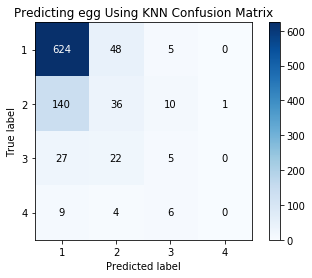

Predicting egg Using KNN Accuracy: 0.7097118463180363 Precision:0.3248951048951049 Recall:0.3017048508077268
Predicting egg Using KNN model's accuracy is 0.7247798742138365, with a standard deviation of 0.01964101334220897


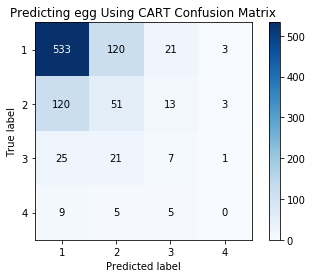

Predicting egg Using CART Accuracy: 0.6307363927427961 Precision:0.2967235335294913 Recall:0.2974134501091665
Predicting egg Using CART model's accuracy is 0.647310165938244, with a standard deviation of 0.02412435830565187


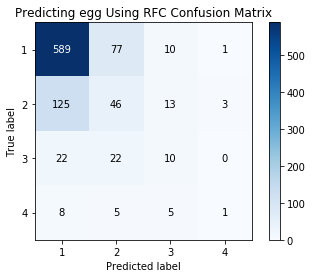

Predicting egg Using RFC Accuracy: 0.6894343649946638 Precision:0.3903728070175438 Recall:0.33845520999853307
Predicting egg Using RFC model's accuracy is 0.6872675265607789, with a standard deviation of 0.019047051558805515


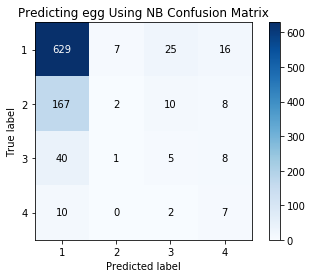

Predicting egg Using NB Accuracy: 0.6862326574172892 Precision:0.3105084041254254 Recall:0.35020194960413376
Predicting egg Using NB model's accuracy is 0.6825487687879758, with a standard deviation of 0.027723607074071503


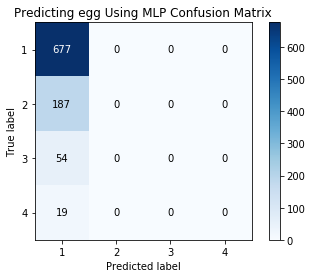

Predicting egg Using MLP Accuracy: 0.7225186766275347 Precision:0.18062966915688367 Recall:0.25
Predicting egg Using MLP model's accuracy is 0.7264694595458906, with a standard deviation of 0.026605723259854958


In [41]:
perform_ml(cleaned_ml_egg_df,"egg")

### Result

It seems like the algorithm is able to predict the lower level class better. It completely fails in predicting the highist level class in all algorithms.


This could be that there is not enough data in the higher class for the algorithm to learn. From the heap map we drew, we can also see that none of the features has a strong correlation with our outcome variable. To improve this we'll first try to look at the number of entries in each class for our outcome variable, and adjust the bins accordingly. Then we will try a few performance improving method such as boosting and bagging. Lastly we will explore other available datasets to serve as features. 

#####  Count Number of Entries in Each Class

In [42]:
for i in range(1,cleaned_ml_egg_df["eggs_group"].max()+1):
    print("Class {} has {} entries".format(i,cleaned_ml_egg_df[cleaned_ml_egg_df["eggs_group"] == i].shape[0]))

Class 1 has 4531 entries
Class 2 has 1222 entries
Class 3 has 372 entries
Class 4 has 117 entries


We can see that only the lower two classes have very little numbers of entries.Our bins are not very evenly distributed. Let's try tweakin the bin size. 

#####  More with other outcome variables.

Before we try to improve the performance, let's finish performing machine learning on all other variables. 

This cuts the dairy array into 6 bins in equal width


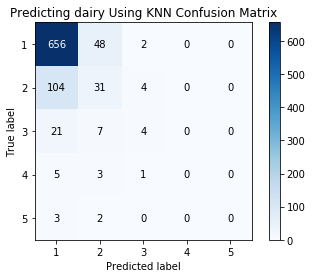

Predicting dairy Using KNN Accuracy: 0.7755331088664422 Precision:0.3071455793889254 Recall:0.25544001059775406
Predicting dairy Using KNN model's accuracy is 0.7707056419927707, with a standard deviation of 0.008509475707549456


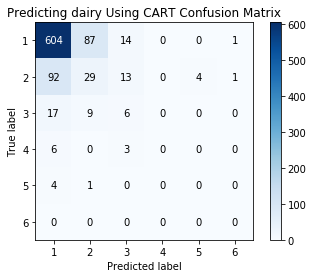

Predicting dairy Using CART Accuracy: 0.7171717171717171 Precision:0.20537223649256844 Recall:0.20860952880754888
Predicting dairy Using CART model's accuracy is 0.7126422285085651, with a standard deviation of 0.011915361117433793


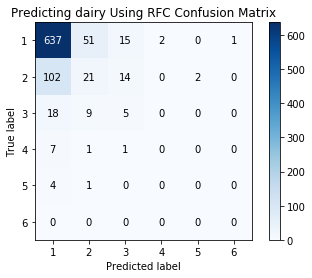

Predicting dairy Using RFC Accuracy: 0.7441077441077442 Precision:0.2042160457305412 Recall:0.20159923760708146
Predicting dairy Using RFC model's accuracy is 0.7471224265283671, with a standard deviation of 0.00965102053993007


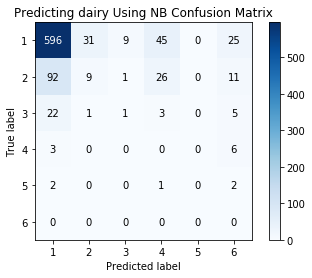

Predicting dairy Using NB Accuracy: 0.6801346801346801 Precision:0.19066461993291262 Recall:0.15669847266662593
Predicting dairy Using NB model's accuracy is 0.6383451202263084, with a standard deviation of 0.04952040787669567


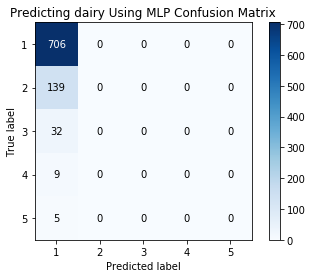

Predicting dairy Using MLP Accuracy: 0.792368125701459 Precision:0.15847362514029179 Recall:0.2
Predicting dairy Using MLP model's accuracy is 0.7754675467546754, with a standard deviation of 0.011988801465309085
This cuts the meat_fish array into 4 bins in equal width


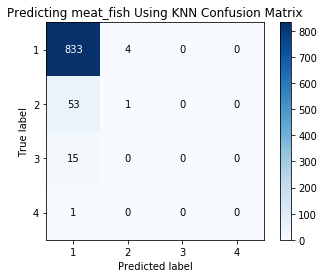

Predicting meat_fish Using KNN Accuracy: 0.9195148842337376 Precision:0.2808758314855876 Recall:0.25343488649940266
Predicting meat_fish Using KNN model's accuracy is 0.933577946162423, with a standard deviation of 0.008483987995959844


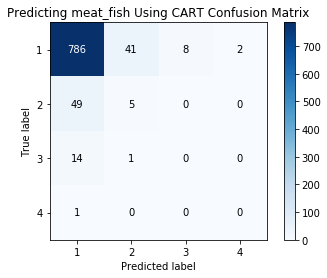

Predicting meat_fish Using CART Accuracy: 0.8721058434399118 Precision:0.25777221526908634 Recall:0.25791517323775387
Predicting meat_fish Using CART model's accuracy is 0.895401658057812, with a standard deviation of 0.011376647613781458


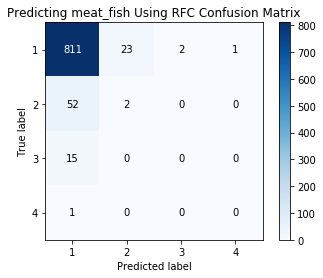

Predicting meat_fish Using RFC Accuracy: 0.896361631753032 Precision:0.2506598407281001 Recall:0.25149342891278376
Predicting meat_fish Using RFC model's accuracy is 0.9172150544974629, with a standard deviation of 0.008172947131752683


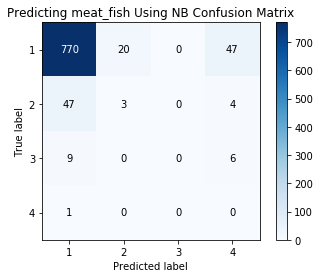

Predicting meat_fish Using NB Accuracy: 0.8522601984564498 Precision:0.2653777403921981 Recall:0.24387694145758662
Predicting meat_fish Using NB model's accuracy is 0.8714390819244393, with a standard deviation of 0.013038663401276157


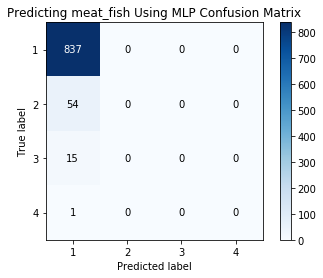

Predicting meat_fish Using MLP Accuracy: 0.9228224917309813 Precision:0.23070562293274532 Recall:0.25
Predicting meat_fish Using MLP model's accuracy is 0.936888373116102, with a standard deviation of 0.007967387038647555
This cuts the nuts_pulses array into 4 bins in equal width


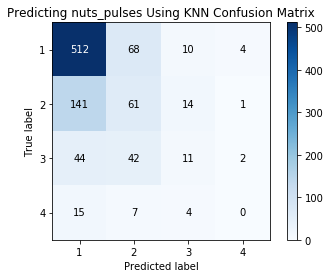

Predicting nuts_pulses Using KNN Accuracy: 0.6239316239316239 Precision:0.3359622587150677 Recall:0.31354249096184583
Predicting nuts_pulses Using KNN model's accuracy is 0.6468624524748605, with a standard deviation of 0.018627033400411833


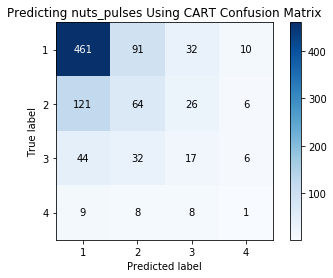

Predicting nuts_pulses Using CART Accuracy: 0.5801282051282052 Precision:0.32562172953790774 Recall:0.3203009654622558
Predicting nuts_pulses Using CART model's accuracy is 0.5859595636570372, with a standard deviation of 0.022612586934653164


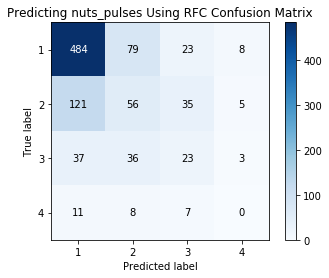

Predicting nuts_pulses Using RFC Accuracy: 0.6014957264957265 Precision:0.3288518213394911 Recall:0.3263006408167698
Predicting nuts_pulses Using RFC model's accuracy is 0.6212184202110649, with a standard deviation of 0.014861908923651607


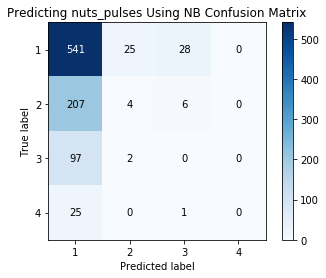

Predicting nuts_pulses Using NB Accuracy: 0.5822649572649573 Precision:0.18771783463107156 Recall:0.23230189762447828
Predicting nuts_pulses Using NB model's accuracy is 0.6034914543580998, with a standard deviation of 0.027810533694193732


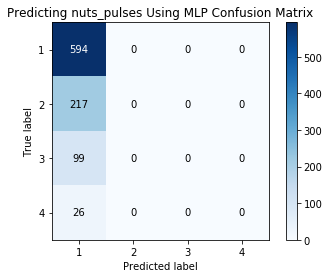

Predicting nuts_pulses Using MLP Accuracy: 0.6346153846153846 Precision:0.15865384615384615 Recall:0.25
Predicting nuts_pulses Using MLP model's accuracy is 0.6564776320932381, with a standard deviation of 0.02021360367168307
This cuts the grains_tubers array into 4 bins in equal width


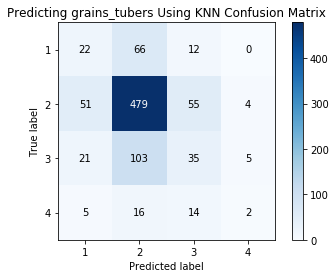

Predicting grains_tubers Using KNN Accuracy: 0.604494382022472 Precision:0.3567875210350283 Recall:0.32517786814517524
Predicting grains_tubers Using KNN model's accuracy is 0.6142256011315418, with a standard deviation of 0.03442319087258443


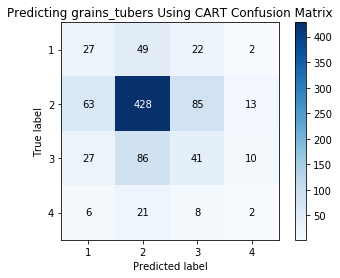

Predicting grains_tubers Using CART Accuracy: 0.5595505617977528 Precision:0.32232087358632633 Recall:0.3251773505253981
Predicting grains_tubers Using CART model's accuracy is 0.570398004086123, with a standard deviation of 0.03320912666158528


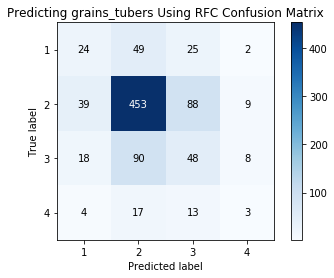

Predicting grains_tubers Using RFC Accuracy: 0.5932584269662922 Precision:0.3596052527594109 Recall:0.3457160444224091
Predicting grains_tubers Using RFC model's accuracy is 0.6070866729530097, with a standard deviation of 0.030955371271950662


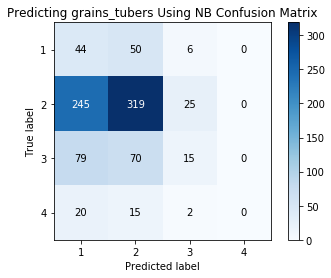

Predicting grains_tubers Using NB Accuracy: 0.4247191011235955 Precision:0.2821363084154594 Recall:0.26826483498281506
Predicting grains_tubers Using NB model's accuracy is 0.4333066163759233, with a standard deviation of 0.11447689891716493


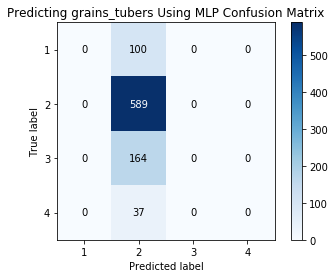

Predicting grains_tubers Using MLP Accuracy: 0.6617977528089888 Precision:0.1654494382022472 Recall:0.25
Predicting grains_tubers Using MLP model's accuracy is 0.6517165645135943, with a standard deviation of 0.029874329756436068
This cuts the animal_source_foods array into 12 bins in equal width


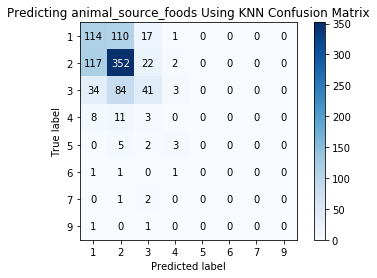

Predicting animal_source_foods Using KNN Accuracy: 0.5410885805763074 Precision:0.1880710025789813 Recall:0.17976959289040548
Predicting animal_source_foods Using KNN model's accuracy is 0.5332615570479338, with a standard deviation of 0.01633668267011932


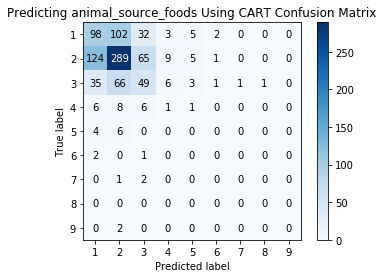

Predicting animal_source_foods Using CART Accuracy: 0.4663820704375667 Precision:0.14919750224595962 Recall:0.14878769505496547
Predicting animal_source_foods Using CART model's accuracy is 0.47276267633159225, with a standard deviation of 0.013906086567710517


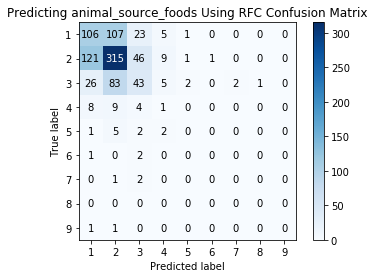

Predicting animal_source_foods Using RFC Accuracy: 0.49626467449306294 Precision:0.1560039154749831 Recall:0.15420537849014637
Predicting animal_source_foods Using RFC model's accuracy is 0.4957591585829514, with a standard deviation of 0.010374395843946019


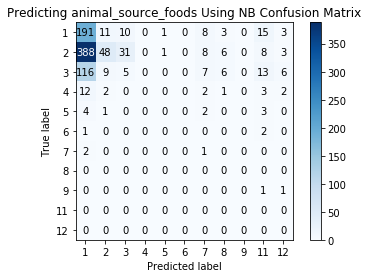

Predicting animal_source_foods Using NB Accuracy: 0.26147278548559233 Precision:0.09890666170158985 Recall:0.11371061930687319
Predicting animal_source_foods Using NB model's accuracy is 0.26558220516647124, with a standard deviation of 0.026107736487534963


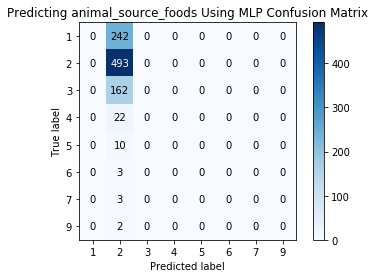

Predicting animal_source_foods Using MLP Accuracy: 0.5261472785485592 Precision:0.0657684098185699 Recall:0.125
Predicting animal_source_foods Using MLP model's accuracy is 0.5217659808833458, with a standard deviation of 0.018184697848720836


In [43]:
# Try it with all others! 
for out_come in dhs_outcome_cols:
    if out_come != "eggs":
        cleaned_outcome_df = clean_outcome(dhs_ml_final_df[[out_come,"Cell_Order"]],out_come)
        cleaned_ml_outcome_df = cleaned_outcome_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
        cleaned_ml_outcome_df = cleaned_ml_outcome_df[desired_group_cols + ["{}_{}".format(out_come,"group")]]
        cleaned_ml_outcome_df.drop(["Cell_Order"], axis=1,inplace = True)
        perform_ml(cleaned_ml_outcome_df,out_come)


##### Try a few Machine Learning Improving Methods 
1) Boosting https://medium.com/greyatom/a-quick-guide-to-boosting-in-ml-acf7c1585cb5
    - In this section we will try: Adaboost XGBoost and GradientBoost
    - Decrease Bias 
2) Bagging https://stats.stackexchange.com/questions/18891/bagging-boosting-and-stacking-in-machine-learning
    - Decrease Variance 
    - In this section, we will try using bagging with our existing models used above. 
    - *Random tree is a bagged algorithm of decision treee

In [44]:
# Boosting 
# Adaboost https://www.datacamp.com/community/tutorials/adaboost-classifier-python
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [45]:

def perform_boosting_ml(df,out_come):
    """
    This function is the driver code for this machine learning prediction.
    Here we are using the default base estimator which is decision tree.
    """
    boosted_models = [('Ada', AdaBoostClassifier(n_estimators=50,learning_rate=1))
                      ,('GB', GradientBoostingClassifier(n_estimators=50,learning_rate=1))
                     ,('XGB', XGBClassifier(n_estimators=50,learning_rate=1))]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', boosted_models, out_come,False)


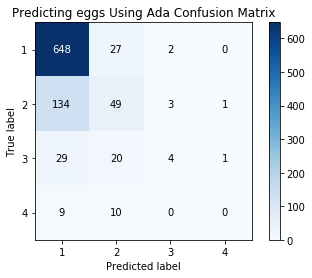

Predicting eggs Using Ada Accuracy: 0.7481323372465315 Precision:0.42423812445671627 Recall:0.3233175295691587
Predicting eggs Using Ada model's accuracy is 0.7379700103045161, with a standard deviation of 0.02467147630507923


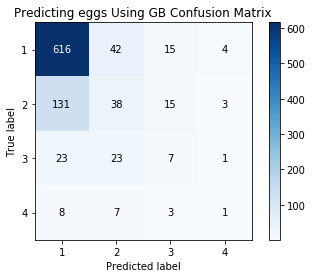

Predicting eggs Using GB Accuracy: 0.7065101387406617 Precision:0.3558348588714913 Recall:0.32384159184637984
Predicting eggs Using GB model's accuracy is 0.7027338947518033, with a standard deviation of 0.021315561089965185


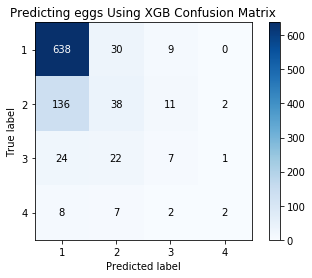

Predicting eggs Using XGB Accuracy: 0.7310565635005336 Precision:0.4561737907746646 Recall:0.34512356339267536
Predicting eggs Using XGB model's accuracy is 0.7270376292506129, with a standard deviation of 0.024370999190998586


In [46]:
perform_boosting_ml(cleaned_ml_egg_df,"eggs")

The results above looks promising, the metrics have all improved. Next step I will use GridSearch, a method for finding the best hyperparameters to improve the performance more. 

In [162]:

from sklearn.model_selection import GridSearchCV

In [187]:
# With GridSearch
def perform_grid_boosting_ml(df,out_come):
    """
    This function is the driver code for this machine learning prediction
    Args:
        bin_class: A boolean variable decides if we bin our label(MMD) or not. 
    """
    
    
    # This param is from https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
    grad_parameters = {
        "learning_rate": [0.5, 0.8, 0.9, 1],
        "subsample":[0.5, 0.8,0.9,1.0],
        "n_estimators":[10]
        }
    
    boosted_models = [
#                         ('Ada', GridSearchCV(AdaBoostClassifier(),parameters,cv=10,n_jobs =-1))
#                       ,('GB', GridSearchCV(GradientBoostingClassifier(),parameters,cv=10,n_jobs =-1))
        ('GB', GridSearchCV(GradientBoostingClassifier(),parameters,cv=10,n_jobs =-1))
#                       ,('XGB', GridSearchCV(XGBClassifier(),parameters,cv=10,n_jobs =-1))
                     ]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', boosted_models, out_come,True)
    

In [186]:
perform_grid_boosting_ml(cleaned_ml_egg_df,"eggs")

ValueError: Invalid parameter subsample for estimator AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=10, random_state=None). Check the list of available parameters with `estimator.get_params().keys()`.

In [47]:
#Bagging 
from sklearn.ensemble import BaggingClassifier

In [116]:
def perform_bagging_ml(df,out_come):
    """
    This function is the driver code for this machine learning prediction
    Args:
        bin_class: A boolean variable decides if we bin our label(MMD) or not. 
    """
    bagged_models = [('KNN', BaggingClassifier(base_estimator= KNeighborsClassifier(), n_estimators=10, max_samples=10, max_features=1.0))
                       , ('CART', BaggingClassifier(base_estimator= DecisionTreeClassifier(), n_estimators=10, max_samples=10, max_features=1.0))
                    ,('NB', BaggingClassifier(base_estimator= GaussianNB(), n_estimators=10, max_samples=10, max_features=1.0))]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', bagged_models, out_come, False)

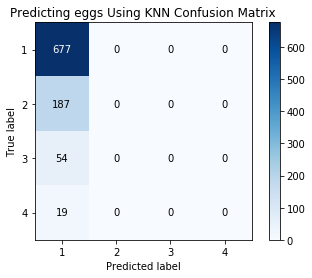

Predicting eggs Using KNN Accuracy: 0.7225186766275347 Precision:0.18062966915688367 Recall:0.25
Predicting eggs Using KNN model's accuracy is 0.7264694595458906, with a standard deviation of 0.026605723259854958


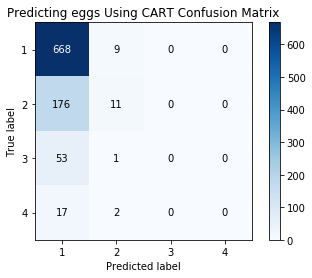

Predicting eggs Using CART Accuracy: 0.7246531483457844 Precision:0.3022785653125297 Recall:0.2613823963854375
Predicting eggs Using CART model's accuracy is 0.7119646093167038, with a standard deviation of 0.04260726857824358


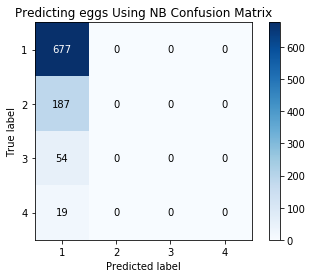

Predicting eggs Using NB Accuracy: 0.7225186766275347 Precision:0.18062966915688367 Recall:0.25
Predicting eggs Using NB model's accuracy is 0.7264694595458906, with a standard deviation of 0.026605723259854958


In [117]:
perform_bagging_ml(cleaned_ml_egg_df,"eggs")

The accuracy is about the same.  I don't think I'll go further into this. 

### New Binning Strategies 

Since our egg class is not very evenly distributed, we are going to divide it more evenly and see if it improves our model performance.
We will first try to bin them so that each class will have equal number of entries. 
If the bin edges are not good enough, we will first build a histogram, and then bin them accordingly.

In [69]:
egg_df = dhs_ml_final_df[["eggs","Cell_Order"]].dropna()

In [63]:


equal_depth_egg_df = create_bins_depth(egg_df,"eggs",4)

cleaned_ml_equal_depth_egg_df = equal_depth_egg_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
cleaned_ml_equal_depth_egg_df = cleaned_ml_equal_depth_egg_df[desired_group_cols + ["eggs_group"]]
cleaned_ml_equal_depth_egg_df.drop(["Cell_Order"], axis=1,inplace = True)




This cuts the eggs array into [0.         0.05538462 0.14285714 0.24615385 1.        ] result in 4 bins in equal depth


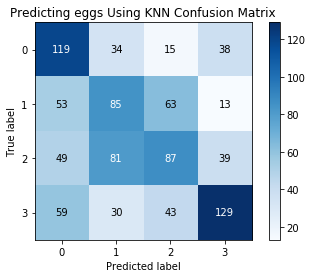

Predicting eggs Using KNN Accuracy: 0.44823906083244397 Precision:0.4504688860127365 Recall:0.4522406970395207
Predicting eggs Using KNN model's accuracy is 0.42375439718580105, with a standard deviation of 0.02333869439445014


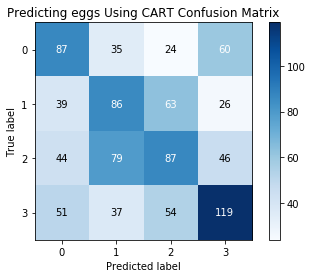

Predicting eggs Using CART Accuracy: 0.4044823906083244 Precision:0.40305422242726713 Recall:0.40499542582097275
Predicting eggs Using CART model's accuracy is 0.3781302632981559, with a standard deviation of 0.015293377360244621


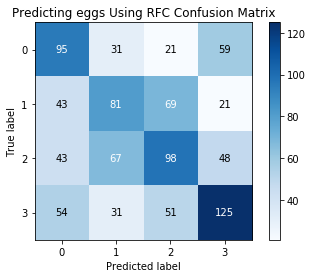

Predicting eggs Using RFC Accuracy: 0.4258271077908218 Precision:0.42352064802811634 Recall:0.4253523561265049
Predicting eggs Using RFC model's accuracy is 0.3956678392495469, with a standard deviation of 0.014157213765140253


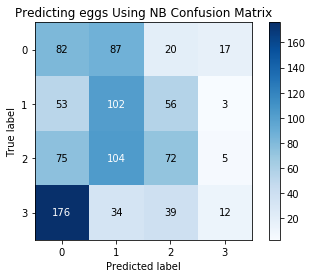

Predicting eggs Using NB Accuracy: 0.28601921024546423 Precision:0.3084282252393619 Recall:0.3004801944850322
Predicting eggs Using NB model's accuracy is 0.27822726788188895, with a standard deviation of 0.01994631158510473


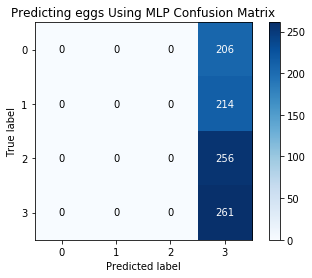

Predicting eggs Using MLP Accuracy: 0.27854855923159016 Precision:0.06963713980789754 Recall:0.25
Predicting eggs Using MLP model's accuracy is 0.27616956259105285, with a standard deviation of 0.025983465005624748


In [102]:
perform_ml(cleaned_ml_equal_depth_egg_df,"eggs")

In [152]:
# This new binning method is not so great. 
# Gonna try differnt method

bins = [0,0.1,0.2,0.5]
egg_df["eggs_group"] = np.digitize(egg_df["eggs"], bins)
cleaned_ml_our_bin_egg_df = egg_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
cleaned_ml_our_bin_egg_df = cleaned_ml_our_bin_egg_df[desired_group_cols + ["eggs_group"]]
cleaned_ml_our_bin_egg_df.drop(["Cell_Order"], axis=1,inplace = True)

In [153]:
cleaned_ml_our_bin_egg_df.head()

,ari_employment value (AVG 2011-2013)_group,agri_gdp_percentage(AVG from 2011 to 2013)_group,AVG GDP 2011-2013 Constant 2010_group,Cons_kg.yr Cereals - Excluding Beer_group,Cons_kg.yr Eggs_group,"Cons_kg.yr Fish, Seafood_group",Cons_kg.yr Meat_group,Cons_kg.yr Milk - Excluding Butter_group,Cons_kg.yr Nuts_and_Seeds_group,Cons_kg.yr Pulses_group,...,Agricultural Emissions (CO2eq)_group,Protected_Terrestrial_group,Forest_change_group,Redlist_group,Freshwater_group,Population_2015_group,Travel_time_to_cities_group,Soil_suit_overall_group,Soil_suit_cereals_group,eggs_group
0,4,2,143040,20,4,4,10,31,1,1,...,3,1,6,2,5,1,9,5,5,3
1,6,2,6613,21,2,3,7,31,1,1,...,1,1,1,3,5,1,8,5,5,1
2,6,2,6613,21,2,3,7,31,1,1,...,1,1,1,3,5,1,10,5,5,2
3,6,2,6613,21,2,3,7,31,1,1,...,1,1,1,3,5,2,10,4,4,3
4,4,2,143040,20,4,4,10,31,1,1,...,3,1,6,2,5,4,6,5,5,1


In [154]:
for i in range(1,cleaned_ml_our_bin_egg_df["eggs_group"].max()+1):
    print("Class {} has {} entries".format(i,cleaned_ml_our_bin_egg_df[cleaned_ml_our_bin_egg_df["eggs_group"] == i].shape[0]))

Class 1 has 1918 entries
Class 2 has 1841 entries
Class 3 has 1812 entries
Class 4 has 485 entries


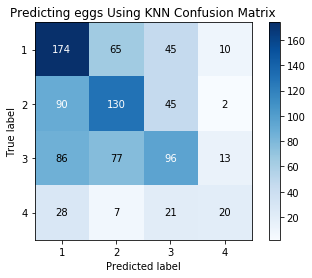

Predicting eggs Using KNN Accuracy: 0.46204620462046203 Precision:0.45861996037311603 Recall:0.42370679791727456
Predicting eggs Using KNN model's accuracy is 0.4509387631747951, with a standard deviation of 0.020610123401180853


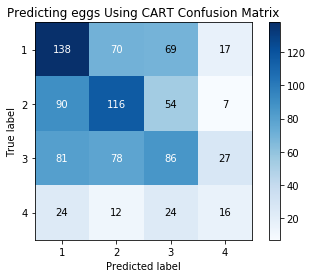

Predicting eggs Using CART Accuracy: 0.39163916391639164 Precision:0.36065223802062096 Recall:0.3576368675796753
Predicting eggs Using CART model's accuracy is 0.40702693513656457, with a standard deviation of 0.020579837706604424


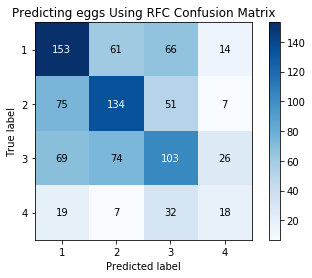

Predicting eggs Using RFC Accuracy: 0.44884488448844884 Precision:0.4138344243049802 Recall:0.40944984957318237
Predicting eggs Using RFC model's accuracy is 0.43636470099354, with a standard deviation of 0.023001097333368033


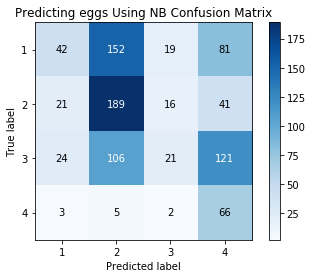

Predicting eggs Using NB Accuracy: 0.34983498349834985 Precision:0.36511736452849264 Recall:0.4490873115952472
Predicting eggs Using NB model's accuracy is 0.31960371727550907, with a standard deviation of 0.023247025651451713


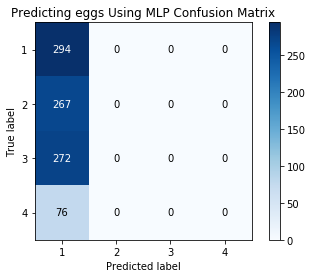

Predicting eggs Using MLP Accuracy: 0.3234323432343234 Precision:0.08085808580858085 Recall:0.25
Predicting eggs Using MLP model's accuracy is 0.31552604737259643, with a standard deviation of 0.019730628627890573


In [155]:
perform_ml(cleaned_ml_our_bin_egg_df,"eggs")

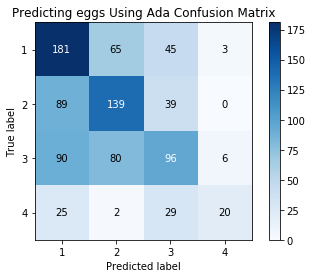

Predicting eggs Using Ada Accuracy: 0.47964796479647964 Precision:0.5262822930245799 Recall:0.43808614516179034
Predicting eggs Using Ada model's accuracy is 0.48764950322994977, with a standard deviation of 0.029114853135315307


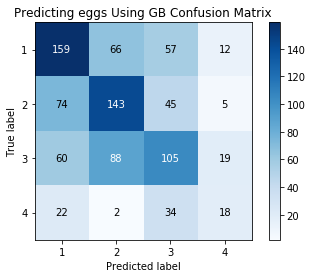

Predicting eggs Using GB Accuracy: 0.4675467546754675 Precision:0.43801018874084 Recall:0.42481709197576134
Predicting eggs Using GB model's accuracy is 0.4719198368025387, with a standard deviation of 0.026598386600672545


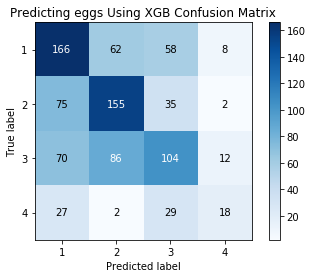

Predicting eggs Using XGB Accuracy: 0.48734873487348734 Precision:0.47737449320423686 Recall:0.4410863103372632
Predicting eggs Using XGB model's accuracy is 0.48493936760983714, with a standard deviation of 0.01920116550794605


In [156]:
perform_boosting_ml(cleaned_ml_our_bin_egg_df,"eggs")

### Regression Models 

###  New Features

1) Road Density https://datacatalog.worldbank.org/dataset/grip-global-roads-inventory-dataset-2018-road-density (Ask Mike for help)
2) Global Cropland and Field Size Still waiting on this resource
3) Add More Country Level Data 
